In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)
from datetime import date, timedelta
from scipy import stats
import scipy.optimize as sco
import random
import warnings
warnings.filterwarnings("ignore")

In [85]:
symbol = pd.read_csv("nasdaq_stocks.csv")
symbol_dict = dict(zip(symbol["Name"], symbol["Symbol"]))
#stocks = ["Apple Inc.", "Amazon.com Inc.", "Alphabet Inc.", "Netflix Inc.", "Tesla Inc."]
stocks = random.sample(list(symbol_dict.keys()), 10)
stocks = [symbol_dict[i] for i in stocks]

In [86]:
stocks

['VII', 'NIMC', 'CBZ', 'KIDS', 'HUGS', 'AES', 'MMX', 'HOMB', 'IACA', 'RMI']

In [87]:
data = pdr.get_data_yahoo(stocks, start=date.today()-timedelta(365*6), end=date.today()-timedelta(365))["Adj Close"]

[*********************100%***********************]  10 of 10 completed

4 Failed downloads:
- IACA: Data doesn't exist for startDate = 1436639400, endDate = 1594319400
- VII: Data doesn't exist for startDate = 1436639400, endDate = 1594319400
- NIMC: Data doesn't exist for startDate = 1436639400, endDate = 1594319400
- HUGS: Data doesn't exist for startDate = 1436639400, endDate = 1594319400


In [88]:
list(set(data.columns) - set(data.dropna(axis=1).columns))

['RMI', 'MMX', 'KIDS', 'IACA', 'VII', 'NIMC', 'HUGS']

In [89]:
data = data.dropna(axis=1)

In [90]:
data

,AES,CBZ,HOMB
Date,,,
2015-07-13,10.486499,9.850000,16.440649
2015-07-14,10.542751,9.930000,16.440649
2015-07-15,10.590966,9.900000,16.664299
2015-07-16,10.727572,9.910000,16.927422
2015-07-17,10.615073,9.940000,16.931812
...,...,...,...
2020-07-02,14.070487,23.879999,14.736737
2020-07-06,14.060770,23.740000,14.804873
2020-07-07,13.740103,23.120001,14.308458


In [91]:
def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights)*252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))*np.sqrt(252)
    return std, returns

def neg_prob_sharpe_ratio(weights, mean_returns, log_returns, cov_matrix, risk_free_rate, sharpe_ratio_benchmark):
    p_var, p_ret = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
    sharpe_ratio = (p_ret - risk_free_rate)/p_var
    coskew = pd.Series(stats.skew(mean_returns), index=mean_returns.index).mean()
    cokurt = pd.Series(stats.kurtosis(mean_returns, fisher=False), index=mean_returns.index).mean()    
    sharpe_ratio_stdev = np.sqrt((1+(0.5*sharpe_ratio**2) - coskew*sharpe_ratio) + (((cokurt-3)/4)*sharpe_ratio**2))/(len(mean_returns)-1)
    prob_sharpe_ratio = stats.norm.cdf((sharpe_ratio - sharpe_ratio_benchmark)/sharpe_ratio_stdev)
    return -1*prob_sharpe_ratio

def max_sharpe_ratio(mean_returns, log_returns, cov_matrix, risk_free_rate, sharpe_ratio_benchmark=0.0):
    num_assets = len(mean_returns)
    args = (mean_returns, log_returns, cov_matrix, risk_free_rate, sharpe_ratio_benchmark)
    constraints = ({"type": "eq", "fun": lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_prob_sharpe_ratio, num_assets*[1./num_assets,], args=args, method="SLSQP", bounds=bounds, constraints=constraints)
    return result

def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualized_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({"type": "eq", "fun": lambda x: np.sum(x) - 1})
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method="SLSQP", bounds=bounds, constraints=constraints)
    return result

def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualized_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({"type": "eq", "fun": lambda x: portfolio_return(x) - target}, {"type": "eq", "fun": lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method="SLSQP", bounds=bounds, constraints=constraints)
    return result

def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [92]:
returns = data.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
risk_free_rate = 0.0178
log_returns = np.log(data/data.shift(1))
log_returns = log_returns.dropna()

In [93]:
max_sharpe = max_sharpe_ratio(mean_returns, log_returns, cov_matrix, risk_free_rate, sharpe_ratio_benchmark=1.0)
sdp, rp = portfolio_annualized_performance(max_sharpe["x"], mean_returns, cov_matrix)
max_sharpe_allocation = pd.DataFrame(max_sharpe["x"], index=data.columns, columns=["allocation"])
max_sharpe_allocation["allocation"] = [round(i*100, 2)for i in max_sharpe_allocation["allocation"]]
max_sharpe_allocation = max_sharpe_allocation.T

min_vol = min_variance(mean_returns, cov_matrix)
sdp_min, rp_min = portfolio_annualized_performance(min_vol["x"], mean_returns, cov_matrix)
min_vol_allocation = pd.DataFrame(min_vol.x,index=data.columns,columns=["allocation"])
min_vol_allocation["allocation"] = [round(i*100,2)for i in min_vol_allocation["allocation"]]
min_vol_allocation = min_vol_allocation.T

an_vol = np.std(returns)*np.sqrt(252)
an_rt = mean_returns*252

In [94]:
print("\nMaximum Sharpe Ratio Portfolio Allocation")
print("Annualized Return:", round(rp, 2))
print("Annualized Volatility:", round(sdp, 2))
print(max_sharpe_allocation)

print("\nMinimum Volatility Portfolio Allocation")
print("Annualized Return:", round(rp_min, 2))
print("Annualized Volatility:", round(sdp_min, 2))
print(min_vol_allocation)

print("\nIndividual Stock Returns and Volatility")
for i, txt in enumerate(data.columns):
    print("{}: Annualized Return: {}; Annualized Volatility: {}".format(txt, round(an_rt[i], 2), round(an_vol[i], 2)))


Maximum Sharpe Ratio Portfolio Allocation
Annualized Return: 0.2
Annualized Volatility: 0.27
            AES    CBZ  HOMB
allocation  0.0  100.0   0.0

Minimum Volatility Portfolio Allocation
Annualized Return: 0.17
Annualized Volatility: 0.25
              AES    CBZ  HOMB
allocation  27.17  68.39  4.44

Individual Stock Returns and Volatility
AES: Annualized Return: 0.11; Annualized Volatility: 0.34
CBZ: Annualized Return: 0.2; Annualized Volatility: 0.27
HOMB: Annualized Return: 0.03; Annualized Volatility: 0.38


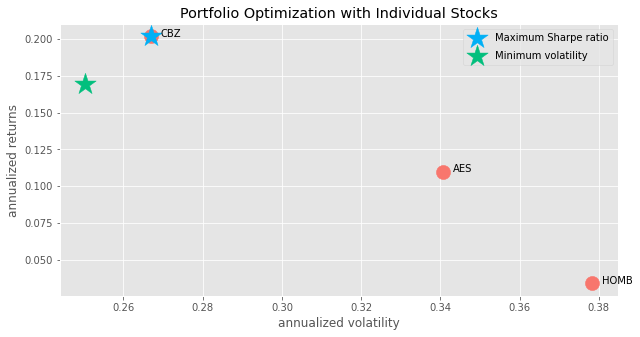

In [95]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(an_vol, an_rt, marker="o", color="#f8766d", s=200)

for i, txt in enumerate(data.columns):
    ax.annotate(txt, (an_vol[i], an_rt[i]), xytext=(10, 0), textcoords="offset points")

ax.scatter(sdp, rp, marker="*", color="#01b0f6", s=500, label="Maximum Sharpe ratio")
ax.scatter(sdp_min, rp_min, marker="*", color="#02bf7d", s=500, label="Minimum volatility")

#target = np.linspace(rp_min, 0.34, 50)
#efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)

#ax.plot([pf["fun"] for pf in efficient_portfolios], target, linestyle="-.", color="black", label="efficient frontier")
ax.set_title("Portfolio Optimization with Individual Stocks")
ax.set_xlabel("annualized volatility")
ax.set_ylabel("annualized returns")
ax.legend(labelspacing=0.8)
plt.show(fig)

In [96]:
df_test = pdr.get_data_yahoo(list(data.columns), start=date.today()-timedelta(365))["Adj Close"]

[*********************100%***********************]  3 of 3 completed


In [97]:
ret_sharpe = 0
for i in df_test.columns:
    ret_sharpe += df_test[i]*max_sharpe_allocation.reset_index(drop=True)[i][0]
ret_sharpe /= 100

ret_vol = 0
for i in df_test.columns:
    ret_vol += df_test[i]*min_vol_allocation.reset_index(drop=True)[i][0]
ret_vol /= 100

In [98]:
df_test["MSP"] = ret_sharpe
df_test["MVP"] = ret_vol

In [99]:
if df_test.isna().sum().sum() > 0:
    df_test = df_test.dropna()

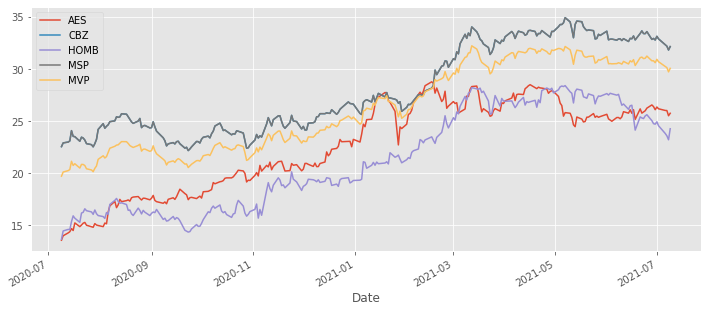

In [100]:
df_test.plot(figsize=(12,5),legend=True)
plt.show()

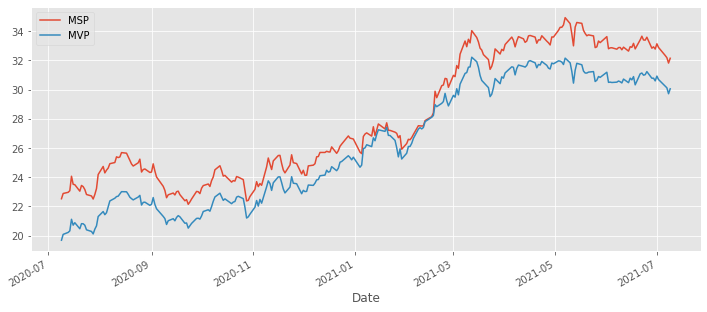

In [101]:
df_test[["MSP", "MVP"]].plot(figsize=(12,5),legend=True)
plt.show()

In [102]:
(df_test["MSP"][-1] - df_test["MSP"][0])/df_test["MSP"][0] * 100

42.717578758167

In [103]:
(df_test["MVP"][-1] - df_test["MVP"][0])/df_test["MVP"][0] * 100

52.672254319867406

In [104]:
df_test

,AES,CBZ,HOMB,MSP,MVP
Date,,,,,
2020-07-09,13.526323,22.520000,13.617369,22.520000,19.681142
2020-07-10,13.953880,22.879999,14.415527,22.879999,20.078950
2020-07-13,14.225964,22.959999,14.561532,22.959999,20.214070
2020-07-14,14.342568,23.070000,14.551799,23.070000,20.320548
2020-07-15,14.643800,24.059999,15.311023,24.059999,21.113163
...,...,...,...,...,...
2021-07-02,26.160000,32.880001,24.530001,32.880001,30.683437
2021-07-06,26.000000,32.330002,23.790001,32.330002,30.230964
2021-07-07,25.990000,32.180000,23.559999,32.180000,30.115449
